## Import modules and environments

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict
import operator

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [2]:
import gym
env_cartpole = gym.envs.make("CartPole-v0") # Has two actions, See doc for mor info, ??env_cartpole.env
env_car = gym.envs.make("MountainCar-v0")   # Has three actions
env_pen = gym.envs.make("Pendulum-v0")      # Has continious action values like array([-1.2552279] or array([1.7774895] 
env_acrobot = gym.envs.make("Acrobot-v1")   # Has Three actions, applying +1, 0 or -1 torque on the joint between #
                                            # the two pendulum links.   See doc for more info, ??env_acrobot.env

C:\Users\marvi\Anaconda3\envs\rl2019\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
#??env_acrobot.env
#env_acrobot.action_space.sample()
#env = env_cartpole
env = env_car
#env = env_acrobot

In [4]:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"  
device = "cpu"
print(device)

cpu


### Test demo environment

In [5]:
import time
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
env.close()  # Close the environment or you will have a lot of render screens soon

### Our DQN model

In [6]:
class QNetwork(nn.Module):
    
    def __init__(self, device,num_input=4,num_hidden=128,num_output=2):
        nn.Module.__init__(self)
        self.device = device
        self.l1 = nn.Linear(num_input, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_output)
        self.input_dim = num_input
        self.hidden_dim = num_hidden
        self.output_dim = num_output

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.Tensor(x)
            
        x = x.to(self.device)
        
        forward_pass = nn.Sequential(
            self.l1,
            nn.ReLU(),
            self.l2
        )
        
        return forward_pass(x)

### Epsilon ($\epsilon$) greedy policy

In [7]:
def get_epsilon(it):
    # YOUR CODE HERE
    epsilon = 1 - (min(it,1000) * 0.00095) #After 1000 iterations epsilon should be 0.05
    
    return epsilon

In [8]:
def parameter_schedule(it,max_iter,initial_value,final_value):
    #Following general formula of get epislon
    parameter_value = initial_value - (min(it,max_iter) * ( (initial_value - final_value) / max_iter) )
                            
    return parameter_value

In [9]:
def select_action(model, state, epsilon):
    # YOUR CODE HERE
    with torch.no_grad():
        Q_approx = model(state)
        a = int(np.random.rand() * model.output_dim) if np.random.rand() < epsilon else torch.argmax(Q_approx).item()
        
    return a

### Experience replays types

#### Uniform

In [10]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.name = "uniform"

    def push(self, transition):
        
        if len(self.memory) == self.capacity:
            self.memory = self.memory[1:]   
        
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory)

#### Prioritized Replay

In [11]:
from segment_tree import SumSegmentTree, MinSegmentTree

#Source OpenAI: https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, alpha):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha >= 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0
        self.name = "prioritized"

    def add(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super().add(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        p_total = self._it_sum.sum(0, len(self._storage) - 1)
        every_range_len = p_total / batch_size
        for i in range(batch_size):
            mass = random.random() * every_range_len + i * every_range_len
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, beta):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)
            
def train_prioritized(model, memory, optimizer, batch_size, discount_factor,beta,prioritized_replay_eps=1e-6):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    #----------------------------#Adjusted of normal train--------------------------------------------------------
    transitions = memory.sample(batch_size, beta=beta)
    (state, action, reward, next_state, done, weights, batch_idxes) = transitions#zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float, device = model.device)
    action = torch.tensor(action, dtype=torch.int64, device = model.device)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float, device = model.device)
    reward = torch.tensor(reward, dtype=torch.float, device = model.device)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    weights = torch.tensor(weights, dtype=torch.float, device = model.device)
    #batch_idxes = torch.tensor(batch_idxes, dtype = torch.int64, device = model.device)
    
     #-------------------------------------------------------------------------------------------------------------
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)
    
    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #-------------------------------------------------------------------------------------------------------------
    mean_loss_value = loss.item() 
    
    with torch.no_grad():
        td_errors = F.smooth_l1_loss(q_val, target,reduction="none") #TD errors, 
    #td_errors = train(obses_t, actions, rewards, obses_tp1, dones, weights)
        if model.device == "cpu":
            td_errors = td_errors.detach().numpy()
        else:
            td_errors = td_errors.cpu().detach().numpy()
    new_priorities = np.abs(td_errors) + prioritized_replay_eps
    #new_priorities = np.abs(loss_value) + prioritized_replay_eps
    memory.update_priorities(batch_idxes, new_priorities)
    #-------------------------------------------------------------------------------------------------------------
    
    return mean_loss_value  # Returns a Python scalar, and releases history (similar to .detach())


#### Selective Experience Replay

In [12]:
class SelectiveReplayMemory:
    
    def __init__(self, fifo_capacity, episodic_memory_capacity):
        self.fifo_capacity = fifo_capacity
        self.episodic_capacity = episodic_memory_capacity
        self.fifo_memory = []
        self.episodic_memory = []
        self.name = "selective"

    def push(self, transition):
        
        if len(self.fifo_memory) == self.fifo_capacity:
            self.fifo_memory = self.fifo_memory[1:]   
        
        self.fifo_memory.append(transition)
    
        #Distribution matching selection
        rank_value = np.random.standard_normal(1)
        self.episodic_memory.append( (transition,rank_value) )
        
        if len(self.episodic_memory) > self.episodic_capacity:
            sorted_episodic = sorted(self.episodic_memory, key=operator.itemgetter(1))
            self.episodic_memory = sorted_episodic[1:]    #Smallest value is index 0 to be removed
        
        #Since no dictionairy was/could be used, duplicate states can be present in the episodic memory
        #Or else could use dictionairy of state to rank value and dict state to other details of transition.

    def sample(self, batch_size):
        
        #50% chance to sample from either buffer?
        #samples = random.sample(self.memory,batch_size)
        #samples = random.sample(self.episodic_memory.keys(),batch_size)
        
        #Or concatenate and sample
        concat = self.fifo_memory + [i[0] for i in self.episodic_memory]
        samples = random.sample(concat,batch_size)
        
        return samples

    def __len__(self):
        return len(self.fifo_memory) #+ len(episodic_memory) #Do we count both memories as len? 

#### Hindsight Experience Replay

In [73]:
class Epsilon_Greedy_Goal(nn.Module):
    
    def __init__(self,device,num_input,num_hidden,num_output):
        nn.Module.__init__(self)
        self.device = device
        self.l1 = nn.Linear(num_input, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_output)
        self.input_dim = num_input  #2 times the state size
        self.hidden_dim = num_hidden
        self.output_dim = num_output
        
    def forward(self,model,state,epsilon,goal):
    
        with torch.no_grad():
            
            if np.random.rand() < epsilon:
                
                combined = np.concatenate(state,goal)
                if not torch.is_tensor(combined):
                    combined_tensor = torch.Tensor(combined)

                combined_tensor = combined_tensor.to(self.device)

                forward_pass = nn.Sequential(
                    self.l1,
                    nn.ReLU(),
                    self.l2
                )
                
                output = forward_pass(combined_tensor)
                a_probs = F.softmax(output)
                
                a = np.random.choice(len(a_probs), size=1,p=a_probs)
            else:
                Q_approx = model(state)
                a = torch.argmax(Q_approx).item()
        return a
    
class HindsightReplayMemory:
    
    def __init__(self, capacity, k,env_name):
        self.capacity = capacity
        self.memory = []
        self.k = k
        self.name = "hindsight"
        self.goals = []
        self.env_name = env_name
        self.current_episode = []
            
        if env_name == "Acrobot-v1":
            self.true_goal_func = lambda s: bool(-np.cos(s[0]) - np.cos(s[1] + s[0]) > 1.)
            self.goal_func = lambda s1,s2: (s1 == s2).all()
        elif env_name == "MountainCar-v0":
            self.true_goal_func = lambda s: s[0] >= 0.5 
            self.goal_func = lambda s1,s2: s1[0] == s2[0]
        
    def compute_reward(self,observed_state,goal):
        
        if self.goal_func(observed_state,goal):
            return 0
        
        return -1

    def push(self, transition):
                
        if len(self.memory) == self.capacity:
            self.memory = self.memory[1:]   
        
        self.memory.append(transition)
        self.current_episode.append(transition)
        #goals = 
            
    def add_future_goals(self):
        #reward = compute_reward(transition[0],goal)

        episode_len = len(self.current_episode)

        for i in range(episode_len):
            current_experience = self.current_episode[i]
            observed_state = current_experience[3]
            
            amount_future = (episode_len - (i+1))
            sample_size = self.k if amount_future > self.k else amount_future
            sampled_trans = random.sample(self.current_episode[i+1:],sample_size)
            #new_rewards = [self.compute_reward(observed_state,trans[3]) for trans in sampled_trans]
            new_rewards = [self.compute_reward(observed_state,trans[0]) for trans in sampled_trans]
            #if 0 in new_rewards:
            #    print(new_rewards)
            #local = []
            
            for new_r in new_rewards:
                tmp_exp = list(current_experience)
                tmp_exp[2] = new_r
                tmp_exp = tuple(tmp_exp)
                self.memory.append(tmp_exp)
                #local.append(tmp_exp)
            #if 0 in new_rewards:
            #    print(local)
            
        self.current_episode = []

    def sample(self, batch_size):
        samples = random.sample(self.memory,batch_size)
        
        return samples

    def __len__(self):
        return len(self.memory)

def train_hindsight(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float, device = model.device)
    action = torch.tensor(action, dtype=torch.int64, device = model.device)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float, device = model.device)
    reward = torch.tensor(reward, dtype=torch.float, device = model.device)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

### Training function

In [14]:
def compute_q_val(model, state, action):
    # YOUR CODE HERE
    Q_approx = model(state)
    action_values = torch.gather(Q_approx, dim=1, index=action.reshape(-1,1))
    
    return action_values
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    # YOUR CODE HERE

    Q_approx = model(next_state)
    max_Q = torch.max(Q_approx,dim=1)[0]
    target = reward + discount_factor * max_Q

    indices = torch.tensor(np.where(done),dtype=torch.long, device = model.device)
    target = target.scatter(0, indices.reshape(-1), 0)
    target = target.reshape(-1,1)
        
    return target

def train(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float, device = model.device)
    action = torch.tensor(action, dtype=torch.int64, device = model.device)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float, device = model.device)
    reward = torch.tensor(reward, dtype=torch.float, device = model.device)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [15]:
def run_episodes(train,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate, 
                 beta_max_iter = 1000,beta_start = 0.4,beta_end = 1.0):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    
    for i in tqdm(range(num_episodes)):
        # YOUR CODE HERE
        s = env.reset()
        done = False
        local_steps = 0
        
        while not done:
            epsilon = get_epsilon(global_steps)
            #if memory.name == " hindsight":
            #    goal = ..
            #    a = select_action_func(model, s, epsilon,goal)
            #else:
            a = select_action_func(model, s, epsilon)
            observation,reward,done,info = env.step(a)
            
            global_steps += 1
            local_steps += 1
            
            if memory.name == "prioritized":
                memory.add(s, a, reward, observation, float(done))
                beta = parameter_schedule(global_steps,beta_max_iter,beta_start,beta_end)
                loss = train(model, memory, optimizer, batch_size, discount_factor,beta)
            #elif memory.name == "hindsight":
            #    memory.push((s, a, reward, observation, done),goal) 
            #    loss = train(model, memory, optimizer, batch_size, discount_factor)
            else: #memory.name == "uniform" or memory.name == "selective" or memory.name == "hindsight":
                memory.push((s, a, reward, observation, done))
                loss = train(model, memory, optimizer, batch_size, discount_factor)

            s = observation
        
        episode_durations.append(local_steps)
        
        if memory.name == "hindsight":
            memory.add_future_goals()
        
        #Check for convergance to terminate perhaps?

    return episode_durations

### Experiments

#### Set multiple seeds 

In [16]:
# We will seed the algorithm (before initializing QNetwork!) for reproducability

if "cuda" in device:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42 
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)
np.random.seed(seed) #Added this seed for numpy, as used in selection action

#### Run it

In [71]:
#env = env_cartpole
env = env_car
#env = env_pen
#env = env_acrobot 

In [76]:
#Hyperparameters
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
buffer_size = 10000

#Parameters for network, e.g. hidden dim
num_input = len(env.observation_space.sample())
num_hidden = 128
num_output = env.action_space.n

#Parameters for schedule of beta and alpha for prioritized replay
beta_max_iter = 1000
beta_start = 0.4
beta_end = 1.0
prioritized_replay_alpha = 0.6
#prioritized_replay_eps=1e-6 Set default in the training function

#Parameters for selective
episodic_buffer_size = 12000

#Parameters for hindsight
num_policy_hidden = 128
k = 4
env_name = env.unwrapped.spec.id
bigger_buffer_size = 10000 * k

#Picking the memory
memory_method = 4
if memory_method == 1:  #Uniform
    memory = ReplayMemory(buffer_size)
    train_func = train #Uniform
    select_action_func = select_action #epsilon greedy
    
elif memory_method == 2:   #Prioritzed
    memory = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
    train_func = train_prioritized #Prioritized Replay
    select_action_func = select_action #epsilon greedy

elif memory_method == 3:   #Selective
    memory = SelectiveReplayMemory(buffer_size,episodic_buffer_size)
    train_func = train #same way as uniform
    select_action_func = select_action #epsilon greedy

elif memory_method == 4: #Hindsight
    memory = HindsightReplayMemory(bigger_buffer_size,k,env_name)
    train_func = train #same way as uniform
    #select_action_func = Epsilon_Greedy_Goal(device,2*num_input,num_policy_hidden,num_output)
    select_action_func = select_action #epsilon greedy
    

#Initializing model
model = QNetwork(device,num_input,num_hidden,num_output)
model = model.to(device)

#Running
start_time = time.time()
episode_durations = run_episodes(train_func,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                                beta_max_iter,beta_start,beta_end)
end_time = time.time()

print("Total duration time: ", str(end_time - start_time))


 22%|█████████████████▊                                                              | 134/600 [01:42<05:57,  1.30it/s]


 45%|████████████████████████████████████                                            | 270/600 [03:26<04:21,  1.26it/s]


 68%|██████████████████████████████████████████████████████▏                         | 406/600 [05:08<02:25,  1.33it/s]


 90%|████████████████████████████████████████████████████████████████████████▎       | 542/600 [06:49<00:43,  1.33it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [07:30<00:00,  1.33it/s]

Total duration time:  450.0850245952606


### Plots and analysis

Text(0.5, 1.0, 'Episode durations per episode')

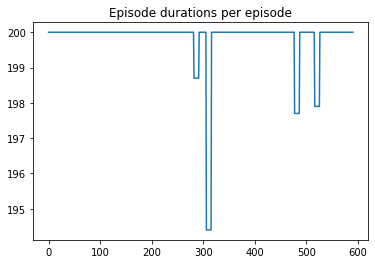

In [77]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')

### With simulation visualization